In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,Occupancy,Hour,Minute
0,21.76,31.13333,1,14,48
1,21.79,31.00000,1,14,49
2,21.77,31.12250,1,14,50
3,21.77,31.12250,1,14,51
4,21.79,31.13333,1,14,51


In [4]:
df_train.shape

(9752, 5)

In [5]:
df_train.duplicated().sum()
df_train = df_train.drop_duplicates(ignore_index=True)

In [6]:
df_val.duplicated().sum()
df_val = df_val.drop_duplicates(ignore_index=True)

In [7]:
df_test.duplicated().sum()
df_test = df_test.drop_duplicates(ignore_index=True)

In [8]:
df_train.shape

(9249, 5)

In [9]:
df_val.shape

(2526, 5)

In [10]:
df_test.shape


(7625, 5)

In [11]:
# Splitting into X and y
X_train = df_train.drop('Occupancy', axis=1).values
y_train = df_train['Occupancy'].values
X_val = df_val.drop('Occupancy', axis=1).values
y_val = df_val['Occupancy'].values
X_test = df_test.drop('Occupancy', axis=1).values
y_test = df_test['Occupancy'].values

In [12]:
 # Column index for minute and hour
time_columns = [2, 3]
# First and second columns are continuous
continuous_columns = [0, 1]

# Scaling oonly first two columns
scaler = StandardScaler()
X_train[:, continuous_columns] = scaler.fit_transform(X_train[:, continuous_columns])
X_test[:, continuous_columns]  = scaler.transform(X_test[:, continuous_columns])
X_val[:, continuous_columns]  = scaler.transform(X_val[:, continuous_columns])

time_scaler = MinMaxScaler()
X_train[:, time_columns] = time_scaler.fit_transform(X_train[:, time_columns])
X_test[:, time_columns]  = time_scaler.transform(X_test[:, time_columns])
X_val[:, time_columns]  = time_scaler.transform(X_val[:, time_columns])
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (9249, 4) (2526, 4) (7625, 4)


In [13]:
# Let's see some values
print("After Scaling :\n", X_train[:3], "\nLabels:", y_train[:3])

After Scaling :
 [[0.72887849 0.32646912 0.60869565 0.81355932]
 [0.7582453  0.2927464  0.60869565 0.83050847]
 [0.73866743 0.32372993 0.60869565 0.84745763]] 
Labels: [1 1 1]


In [14]:
# MAKING SEQUENCES:
window_size = 20
# I need to create a function for making windows
def time_windows(X, y, window_size, step_ahead = 1):
    # Creating two list for features and labels
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size - step_ahead + 1):
        X_windows.append(X[i:i+window_size])
        # so the next step after the window must be predicted
        # if window_size from 0 to 20, the next step is 21
        y_windows.append(y[i+window_size-1 + step_ahead])
    return np.array(X_windows), np.array(y_windows)
# Applying the function:
X_train, y_train = time_windows(X_train, y_train, window_size)
X_val, y_val = time_windows(X_val, y_val, window_size)
X_test, y_test = time_windows(X_test, y_test, window_size)


print('Training sequences shape:', X_train.shape)
print('Training class shape:', y_train.shape)
print('Example  X:', X_train[0])
print("Example  y:", y_train[0])

Training sequences shape: (9229, 20, 4)
Training class shape: (9229,)
Example  X: [[0.72887849 0.32646912 0.60869565 0.81355932]
 [0.7582453  0.2927464  0.60869565 0.83050847]
 [0.73866743 0.32372993 0.60869565 0.84745763]
 [0.73866743 0.32372993 0.60869565 0.86440678]
 [0.7582453  0.32646912 0.60869565 0.86440678]
 [0.72887849 0.35850735 0.60869565 0.89830508]
 [0.7582453  0.34269943 0.60869565 0.91525424]
 [0.7582453  0.39223007 0.60869565 0.93220339]
 [0.7582453  0.37305064 0.60869565 0.93220339]
 [0.7582453  0.40993495 0.60869565 0.96610169]
 [0.7582453  0.42553294 0.60869565 0.96610169]
 [0.7582453  0.43817927 0.60869565 0.98305085]
 [0.7582453  0.39265246 0.65217391 0.        ]
 [0.7582453  0.39202014 0.65217391 0.01694915]
 [0.7582453  0.41920977 0.65217391 0.03389831]
 [0.78761212 0.41920977 0.65217391 0.05084746]
 [0.78761212 0.41225428 0.65217391 0.06779661]
 [0.85613469 0.44450244 0.65217391 0.06779661]
 [0.7582453  0.43185611 0.65217391 0.10169492]
 [0.78761212 0.47738292 0

In [15]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long) 
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test= torch.tensor(X_test, dtype=torch.float32)
y_test= torch.tensor(y_test, dtype=torch.long)

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# I nned to see shape of one batch
for X_batch, y_batch in train_loader:
    print(f"Batch input shape: {X_batch.shape}") 
    print(f"Batch target shape: {y_batch.shape}")
    break  
# In forward function, I will switch input shape and sequence lemght

Batch input shape: torch.Size([128, 20, 4])
Batch target shape: torch.Size([128])


In [17]:
class OccupancyCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First Block 
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        # In first block, the sequence length reduces from 20 to 10
        # Second Block
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        # In second block, the sequence length reduces from 10 to 5
        self.fc1   = nn.Linear(32 * 5, 32)  
        self.fc2   = nn.Linear(32, 1)
        self.drop_conv = nn.Dropout(p=0.5)  
        self.drop_fc   = nn.Dropout(p=0.2) 

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))   
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.drop_conv(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.drop_conv(x)

        x = torch.flatten(x, start_dim=1)  
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)       
        return x
model = OccupancyCNN().to(device)
model
# Sources :
# https://medium.com/@ugamakelechi501/building-a-convolutional-neural-network-cnn-from-scratch-with-pytorch-eca3ffdcf2ff
# https://www.dkneup.com/blog/cnn-time-series-forecasting-in-tensorflow-pytorch

OccupancyCNN(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (drop_conv): Dropout(p=0.5, inplace=False)
  (drop_fc): Dropout(p=0.2, inplace=False)
)

In [18]:
# My target column is imbalanced, there is more 0 than 1
# I need to calculate class weights, that loss function focus more on the unoccupany class.
# First I should convert it back to numpy
y_np = y_train.numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(y_np), y=y_np)
one_weight = torch.tensor(class_weights[1], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=one_weight)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00001)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
print('Optimizer:', optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 1e-05
)


In [20]:
epochs = 20
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(1, epochs+1):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)            
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float() 
        correct += (preds.squeeze() == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    


    val_loss = 0.0
    val_preds = []
    val_targets = []
    model.eval()  
     
    with torch.no_grad():  
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits.squeeze(1), y_batch.float())
            val_loss += loss.item() * X_batch.size(0)


            probs = torch.sigmoid(logits.squeeze(1))
            preds = (probs >= 0.5).to(torch.int64)


            val_preds.extend(preds.tolist())
            val_targets.extend(y_batch.tolist())
    val_loss = val_loss / len(val_dataset)


    
    # Converting predictions and targets to numpy for calculations
    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    
    val_prec = precision_score(val_targets, val_preds, pos_label=1.0, zero_division=0)
    learning_rate = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch:2d}/{epochs} - "f"Train Loss: {train_loss:.4f} "f"Val Loss: {val_loss:.4f}, "
          f"Prec: {val_prec:.3f}, "f"Learning Rate: {learning_rate:.6f}")
    

    scheduler.step(val_loss)


    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
if patience_counter >= patience:
    model.load_state_dict(best_model_state)
#Source: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

Epoch  1/20 - Train Loss: 0.6338 Val Loss: 0.6627, Prec: 0.772, Learning Rate: 0.000500
Epoch  2/20 - Train Loss: 0.4094 Val Loss: 0.7322, Prec: 0.786, Learning Rate: 0.000500
Epoch  3/20 - Train Loss: 0.3773 Val Loss: 0.6446, Prec: 0.756, Learning Rate: 0.000500
Epoch  4/20 - Train Loss: 0.3425 Val Loss: 0.5454, Prec: 0.694, Learning Rate: 0.000500
Epoch  5/20 - Train Loss: 0.3178 Val Loss: 0.5378, Prec: 0.800, Learning Rate: 0.000500
Epoch  6/20 - Train Loss: 0.2912 Val Loss: 0.5164, Prec: 0.672, Learning Rate: 0.000500
Epoch  7/20 - Train Loss: 0.2762 Val Loss: 0.4008, Prec: 0.861, Learning Rate: 0.000500
Epoch  8/20 - Train Loss: 0.2603 Val Loss: 0.4759, Prec: 0.790, Learning Rate: 0.000500
Epoch  9/20 - Train Loss: 0.2532 Val Loss: 0.4083, Prec: 0.901, Learning Rate: 0.000500
Early stopping triggered.


In [21]:
# Evaluation
model.eval()
test_preds = []
test_targets = []
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = criterion(logits.squeeze(), y_batch.float())
        probs = torch.sigmoid(logits.squeeze())
        preds = (probs >= 0.5).to(torch.int64)
        test_loss += loss.item() * X_batch.size(0)

        test_preds.extend(preds.tolist())
        test_targets.extend(y_batch.tolist())
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

Confusion Matrix:


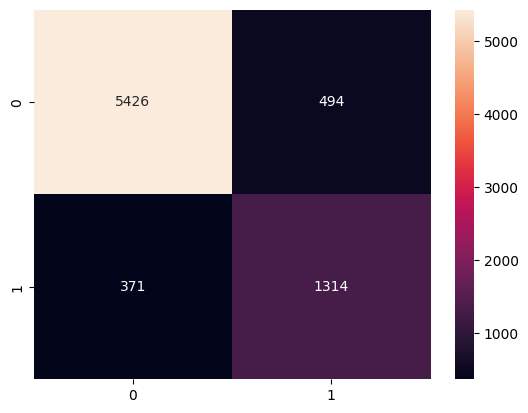

In [22]:
Confusion_matrix = confusion_matrix(test_targets, test_preds)
print("Confusion Matrix:")
sns.heatmap(Confusion_matrix, annot=True, fmt='d')
plt.show()

In [ ]:
Classification_report = classification_report(test_targets, test_preds, target_names=['No Occupancy', 'Occupancy'], zero_division=0)
print("Classification Report:\n", Classification_report)

# Even though I have calculated class weights, but still the model is biased towards the class occupancy.
# The gap between traning and validation loss is big, because the distribution of Occupancy is different in each DS.

Classification Report:
               precision    recall  f1-score   support

No Occupancy       0.94      0.92      0.93      5920
   Occupancy       0.73      0.78      0.75      1685

    accuracy                           0.89      7605
   macro avg       0.83      0.85      0.84      7605
weighted avg       0.89      0.89      0.89      7605

